## Import Packages

In [1]:
import imghdr
import os, cv2, shutil, math, random as rd, numpy as np, matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling

## Dataset Input

In [2]:
data = "D:\kuliah\Magang_Winteq\Project\data"

In [101]:
# src_dir = "D:\kuliah\Magang_Winteq\Project\data\cap_train"
# dst_dir = "D:\kuliah\Magang_Winteq\Project\dataV2\cap"
# files = os.listdir(src_dir)
# files.sort()

# for file in files[:1007]:
#     shutil.move(os.path.join(src_dir, file), dst_dir)


src_dir = "D:\kuliah\Magang_Winteq\Project\data\safety helmet_images"
dst_dir = "D:\kuliah\Magang_Winteq\Project\dataV2\safety_helmet"
files = os.listdir(src_dir)
files.sort()

for file in files[:702]:
    shutil.move(os.path.join(src_dir, file), dst_dir)

## Data Loader

In [3]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = "D:\kuliah\Magang_Winteq\Project\dataV2"
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [5]:
label_counts = {}

for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    image_count = len(os.listdir(class_dir))
    label_counts[image_class] = image_count
    print(f"Label {image_class} has {image_count} images.")

Label cap has 1709 images.
Label safety_helmet has 1708 images.


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),  # Resize with a slight increase in size
    tf.keras.layers.Rescaling(1./255),  # Rescale pixel values to [0,1]
])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess training data with data augmentation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3417 files belonging to 2 classes.
Using 2734 files for training.
Found 3417 files belonging to 2 classes.
Using 683 files for validation.
['cap', 'safety_helmet']


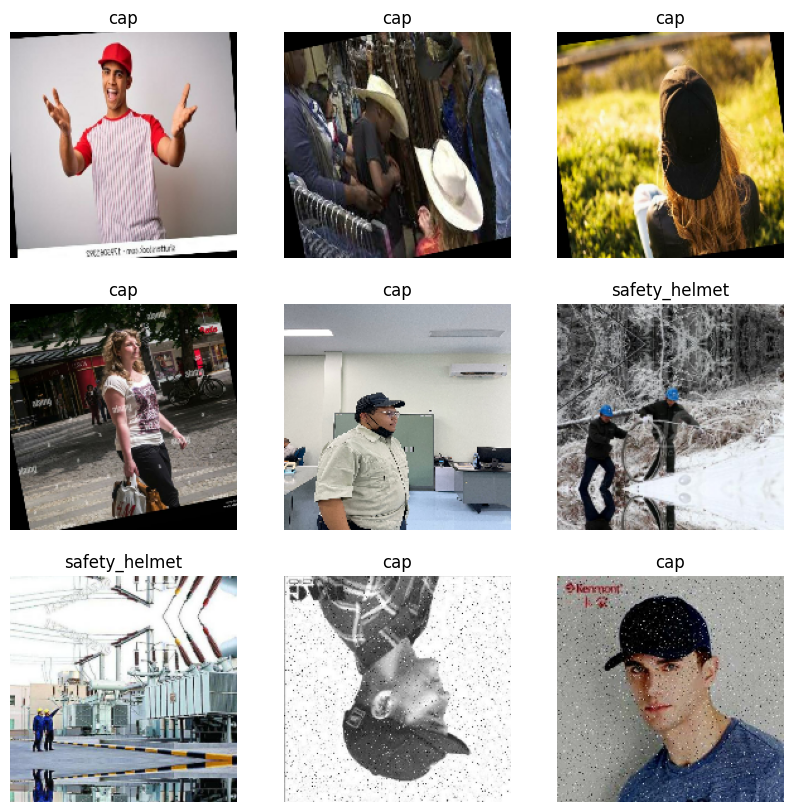

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## Building Architecture

In [16]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training Data

In [18]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/20
86/86 [==============================] - 78s 888ms/step - loss: 0.5795 - accuracy: 0.7714 - val_loss: 40.9103 - val_accuracy: 0.8668
Epoch 2/20
86/86 [==============================] - 75s 861ms/step - loss: 0.2195 - accuracy: 0.9071 - val_loss: 18.5625 - val_accuracy: 0.9268
Epoch 3/20
86/86 [==============================] - 75s 862ms/step - loss: 0.1282 - accuracy: 0.9499 - val_loss: 23.4844 - val_accuracy: 0.9414
Epoch 4/20
86/86 [==============================] - 76s 876ms/step - loss: 0.0900 - accuracy: 0.9685 - val_loss: 41.0386 - val_accuracy: 0.9122
Epoch 5/20
86/86 [==============================] - 74s 854ms/step - loss: 0.0572 - accuracy: 0.9777 - val_loss: 49.8155 - val_accuracy: 0.9414
Epoch 6/20
86/86 [==============================] - 75s 871ms/step - loss: 0.0542 - accuracy: 0.9788 - val_loss: 53.2987 - val_accuracy: 0.9283
Epoch 7/20
86/86 [==============================] - 76s 882ms/step - loss: 0.0242 - accuracy: 0.9912 - val_loss: 51.1127 - val_accuracy:

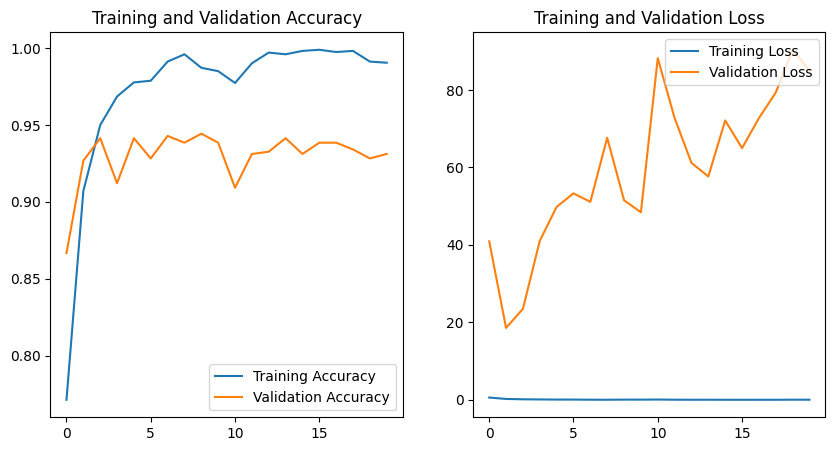

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [3]:
import cv2
import numpy as np

# Fungsi untuk mendeteksi dan menampilkan kotak pada objek menggunakan model
def detect_and_display(frame, model, class_names):
    # Praproses frame
    resized_frame = cv2.resize(frame, (img_width, img_height))
    input_data = np.expand_dims(resized_frame, axis=0) / 255.0

    # Prediksi menggunakan model
    predictions = model.predict(input_data)
    score = tf.nn.softmax(predictions[0])
    class_index = np.argmax(score)
    confidence = 100 * np.max(score)

    # Jika kepercayaan (confidence) lebih dari batas tertentu, tampilkan kotak dan label
    if confidence > 75:
        label = class_names[class_index]
        cv2.putText(frame, f'{label} ({confidence:.2f}%)', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Koordinat kotak
        box_color = (0, 255, 0)  # Warna hijau
        cv2.rectangle(frame, (0, 0), (img_width, img_height), box_color, 2)

    return frame

# Fungsi untuk membaca video dari kamera
def main():
    cap = cv2.VideoCapture(0)  # 0 untuk kamera bawaan

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Deteksi dan tampilkan hasil pada frame
        frame_with_detection = detect_and_display(frame, model, class_names)

        # Tampilkan frame
        cv2.imshow('Safety Helmet and Cap Detection', frame_with_detection)

        # Hentikan aplikasi jika tombol 'q' ditekan
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Tutup video stream dan jendela OpenCV
    cap.release()
    cv2.destroyAllWindows()

# Panggil fungsi main
main()

NameError: name 'model' is not defined

Testing Manual

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to cap with a 100.00 percent confidence.


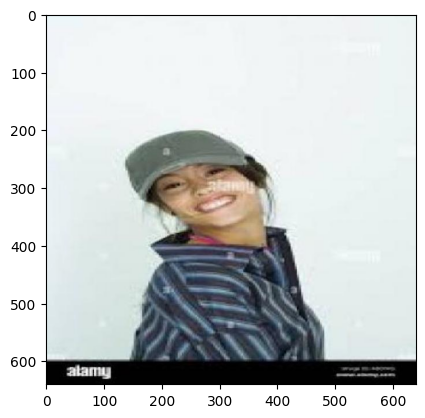

In [21]:
import tensorflow as tf
import numpy as np
from PIL import Image

path = "D:\kuliah\Magang_Winteq\Project\cap_test\image-239-_jpg.rf.4887bc32aed940c70beaaed7713a7e0d.jpg"

im = Image.open(path)
plt.figure()
plt.imshow(im)

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [23]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke folder test cap
test_cap_path = "D:\kuliah\Magang_Winteq\Project\cap_test"

# Inisialisasi variabel
correct_predictions = 0
total_predictions = 0

# Iterasi melalui gambar-gambar di folder test
for filename in os.listdir(test_cap_path):
    if filename.endswith(".jpg"):
        # Path lengkap ke gambar
        img_path = os.path.join(test_cap_path, filename)

        # Load dan preprocess gambar
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Tambahkan dimensi batch
        img_array /= 255.0  # Normalisasi

        # Prediksi menggunakan model
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])

        # Cek apakah prediksi benar
        true_class = 0  # Ganti dengan indeks kelas "cap"
        if predicted_class == true_class:
            correct_predictions += 1

        total_predictions += 1

# Hitung akurasi
accuracy = correct_predictions / total_predictions
print(f"Accuracy on test dataset: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 57ms/step
Accuracy on test dataset: 81.25%


In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke folder test SH
test_SH_path = "D:\kuliah\Magang_Winteq\Project\safety_helmet_test"

# Inisialisasi variabel
correct_predictions = 0
total_predictions = 0

# Iterasi melalui gambar-gambar di folder test
for filename in os.listdir(test_SH_path):
    if filename.endswith(".jpg"):
        # Path lengkap ke gambar
        img_path = os.path.join(test_SH_path, filename)

        # Load dan preprocess gambar
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Tambahkan dimensi batch
        img_array /= 255.0  # Normalisasi

        # Prediksi menggunakan model
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])

        # Cek apakah prediksi benar
        true_class = 0  # Ganti dengan indeks kelas "cap"
        if predicted_class == true_class:
            correct_predictions += 1

        total_predictions += 1

# Hitung akurasi
accuracy = correct_predictions / (total_predictions + 0.01)
print(f"Accuracy on test dataset: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 63ms/step
Accuracy on test dataset: 0.00%
